In [42]:
!pip uninstall -y ragatouille

In [1]:
!pip install torch torchvision

In [2]:
!pip install -U sentence-transformers

In [3]:
!pip install transformers accelerate bitsandbytes langchain sentence-transformers faiss-gpu openpyxl pacmap datasets langchain-community ragatouille matplotlib

  Using cached ragatouille-0.0.8.post4-py3-none-any.whl.metadata (15 kB)
  Using cached sentence_transformers-2.7.0-py3-none-any.whl.metadata (11 kB)
Using cached ragatouille-0.0.8.post4-py3-none-any.whl (41 kB)
Using cached sentence_transformers-2.7.0-py3-none-any.whl (171 kB)
  Attempting uninstall: sentence-transformers
    Found existing installation: sentence-transformers 3.2.0
    Uninstalling sentence-transformers-3.2.0:
      Successfully uninstalled sentence-transformers-3.2.0


In [4]:
import torch

print(torch.cuda.is_available())

True


In [8]:
from tqdm.notebook import tqdm
import pandas as pd
from typing import Optional, List, Tuple
from datasets import Dataset
import matplotlib.pyplot as plt
import os

pd.set_option("display.max_colwidth", None)  # This will be helpful when visualizing retriever outputs

In [9]:
def read_files_in_directory(directory):
    """
    Iterate through all files in the given directory and return their text content.
    """
    file_contents = {}
    
    # Iterate through all files in the directory
    for root, dirs, files in os.walk(directory):
        for file in files:
            file_path = os.path.join(root, file)
            
            # Open and read the file's content
            try:
                with open(file_path, 'r', encoding='utf-8') as f:
                    file_contents[file_path] = f.read()
            except Exception as e:
                print(f"Error reading {file_path}: {e}")
    
    return file_contents

In [10]:
from langchain.docstore.document import Document as LangchainDocument

ds = read_files_in_directory('assets')

RAW_KNOWLEDGE_BASE = [
    LangchainDocument(page_content=value, metadata={"source": key}) for key, value in ds.items()
]

In [11]:
from langchain.text_splitter import RecursiveCharacterTextSplitter

# We use a hierarchical list of separators specifically tailored for splitting Markdown documents
# This list is taken from LangChain's MarkdownTextSplitter class
MARKDOWN_SEPARATORS = [
    "\n#{1,6} ",
    "```\n",
    "\n\\*\\*\\*+\n",
    "\n---+\n",
    "\n___+\n",
    "\n\n",
    "\n",
    " ",
    "",
]

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000,  # The maximum number of characters in a chunk: we selected this value arbitrarily
    chunk_overlap=100,  # The number of characters to overlap between chunks
    add_start_index=True,  # If `True`, includes chunk's start index in metadata
    strip_whitespace=True,  # If `True`, strips whitespace from the start and end of every document
    separators=MARKDOWN_SEPARATORS,
)

docs_processed = []
for doc in RAW_KNOWLEDGE_BASE:
    docs_processed += text_splitter.split_documents([doc])

Model's maximum sequence length: 512


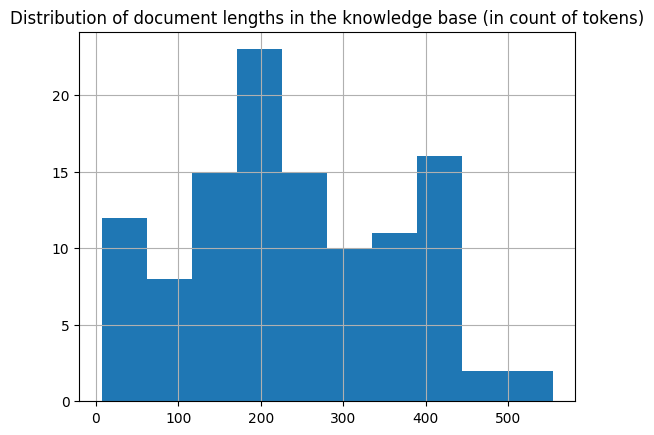

In [12]:
from sentence_transformers import SentenceTransformer

# To get the value of the max sequence_length, we will query the underlying `SentenceTransformer` object used in the RecursiveCharacterTextSplitter
print(f"Model's maximum sequence length: {SentenceTransformer('thenlper/gte-small').max_seq_length}")

from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("thenlper/gte-small")
lengths = [len(tokenizer.encode(doc.page_content)) for doc in docs_processed]

# Plot the distribution of document lengths, counted as the number of tokens
fig = pd.Series(lengths).hist()
plt.title("Distribution of document lengths in the knowledge base (in count of tokens)")
plt.show()

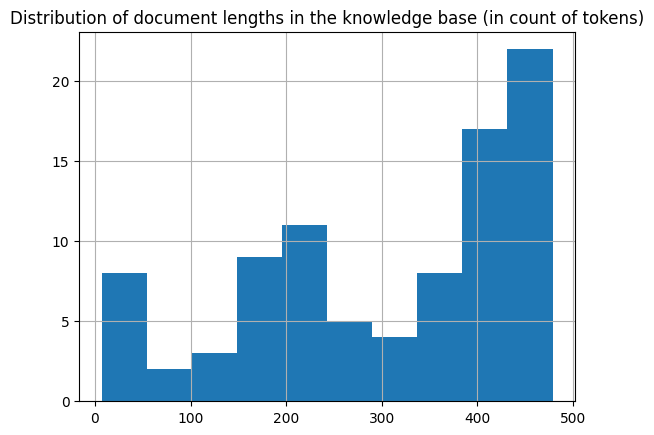

In [14]:
from langchain.text_splitter import RecursiveCharacterTextSplitter
from transformers import AutoTokenizer

EMBEDDING_MODEL_NAME = "thenlper/gte-small"


def split_documents(
    chunk_size: int,
    knowledge_base: List[LangchainDocument],
    tokenizer_name: Optional[str] = EMBEDDING_MODEL_NAME,
) -> List[LangchainDocument]:
    """
    Split documents into chunks of maximum size `chunk_size` tokens and return a list of documents.
    """
    text_splitter = RecursiveCharacterTextSplitter.from_huggingface_tokenizer(
        AutoTokenizer.from_pretrained(tokenizer_name),
        chunk_size=chunk_size,
        chunk_overlap=int(chunk_size / 10),
        add_start_index=True,
        strip_whitespace=True,
        separators=MARKDOWN_SEPARATORS,
    )

    docs_processed = []
    for doc in knowledge_base:
        docs_processed += text_splitter.split_documents([doc])

    # Remove duplicates
    unique_texts = {}
    docs_processed_unique = []
    for doc in docs_processed:
        if doc.page_content not in unique_texts:
            unique_texts[doc.page_content] = True
            docs_processed_unique.append(doc)

    return docs_processed_unique


docs_processed = split_documents(
    512,  # We choose a chunk size adapted to our model
    RAW_KNOWLEDGE_BASE,
    tokenizer_name=EMBEDDING_MODEL_NAME,
)

# Let's visualize the chunk sizes we would have in tokens from a common model
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(EMBEDDING_MODEL_NAME)
lengths = [len(tokenizer.encode(doc.page_content)) for doc in docs_processed]
fig = pd.Series(lengths).hist()
plt.title("Distribution of document lengths in the knowledge base (in count of tokens)")
plt.show()

In [15]:
from langchain.vectorstores import FAISS
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain_community.vectorstores.utils import DistanceStrategy

embedding_model = HuggingFaceEmbeddings(
    model_name=EMBEDDING_MODEL_NAME,
    multi_process=True,
    model_kwargs={"device": "cuda"},
    encode_kwargs={"normalize_embeddings": True},  # Set `True` for cosine similarity
)

KNOWLEDGE_VECTOR_DATABASE = FAISS.from_documents(
    docs_processed, embedding_model, distance_strategy=DistanceStrategy.COSINE
)

/tmp/ipykernel_9200/2775243909.py:5: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  embedding_model = HuggingFaceEmbeddings(


In [16]:
# Embed a user query in the same space
user_query = "What is in your portafolio?"
query_vector = embedding_model.embed_query(user_query)

In [18]:
!pip install plotly

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.1/19.1 MB 19.2 MB/s eta 0:00:0031m20.0 MB/s eta 0:00:01


In [19]:
import pacmap
import numpy as np
import plotly.express as px

embedding_projector = pacmap.PaCMAP(n_components=2, n_neighbors=None, MN_ratio=0.5, FP_ratio=2.0, random_state=1)

embeddings_2d = [
    list(KNOWLEDGE_VECTOR_DATABASE.index.reconstruct_n(idx, 1)[0]) for idx in range(len(docs_processed))
] + [query_vector]

# Fit the data (the index of transformed data corresponds to the index of the original data)
documents_projected = embedding_projector.fit_transform(np.array(embeddings_2d), init="pca")

/home/oscar/miniconda3/envs/jupyter/lib/python3.10/site-packages/pacmap/pacmap.py:822: UserWarning: Warning: random state is set to 1
  warnings.warn(f'Warning: random state is set to {_RANDOM_STATE}')


In [23]:
df = pd.DataFrame.from_dict(
    [
        {
            "x": documents_projected[i, 0],
            "y": documents_projected[i, 1],
            "source": docs_processed[i].metadata["source"].split("/")[1],
            "extract": docs_processed[i].page_content[:100] + "...",
            "symbol": "circle",
            "size_col": 4,
        }
        for i in range(len(docs_processed))
    ]
    + [
        {
            "x": documents_projected[-1, 0],
            "y": documents_projected[-1, 1],
            "source": "User query",
            "extract": user_query,
            "size_col": 100,
            "symbol": "star",
        }
    ]
)

# Visualize the embedding
fig = px.scatter(
    df,
    x="x",
    y="y",
    color="source",
    hover_data="extract",
    size="size_col",
    symbol="symbol",
    color_discrete_map={"User query": "black"},
    width=1000,
    height=700,
)
fig.update_traces(
    marker=dict(opacity=1, line=dict(width=0, color="DarkSlateGrey")),
    selector=dict(mode="markers"),
)
fig.update_layout(
    legend_title_text="<b>Chunk source</b>",
    title="<b>2D Projection of Chunk Embeddings via PaCMAP</b>",
)
fig.show()

AttributeError: 'Figure' object has no attribute 'savefig'

In [24]:
retrieved_docs = KNOWLEDGE_VECTOR_DATABASE.similarity_search(query=user_query, k=5)

In [27]:
print("\n==================================Top document==================================")
print(retrieved_docs[0].page_content)
print("==================================Metadata==================================")
for doc in retrieved_docs:
    print(doc.metadata)


==================================Top document==================================
### Hi there 👋 I'm [Ivan](https://portafolio-ivanromero03.vercel.app)
[![trophy](https://github-profile-trophy.vercel.app/?username=IvanRomero03&theme=onedark&column=6&row=1&margin-w=10)](https://github.com/ryo-ma/github-profile-trophy)


## About me
- 📚I'm a Computer Science Eng. student at Tec. de Monterrey
- 🖥️I'm a SWD at [RoBorregos][Roborregos]
- 😎Currently interning at Tec de Monterrey On Campus Jobs, Central Park Crowd Counting
- ✅Fun Fact: I play the Oboe 🎼
- 💻I'm currently learning **Design Patterns**
==================================Metadata==================================
{'source': 'assets/IvanRomero03_README.md', 'start_index': 0}
{'source': 'assets/deep-person-reid_MODEL_ZOO.md', 'start_index': 1456}
{'source': 'assets/Oscar-gg.github_README.md', 'start_index': 0}
{'source': 'assets/Smart-Office_README.md', 'start_index': -1}
{'source': 'assets/TC2038_algoritmos_README.md', 'start_index'

In [ ]:
from transformers import pipeline
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig

READER_MODEL_NAME = "HuggingFaceH4/zephyr-7b-beta"

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16,
)
model = AutoModelForCausalLM.from_pretrained(READER_MODEL_NAME, quantization_config=bnb_config)
tokenizer = AutoTokenizer.from_pretrained(READER_MODEL_NAME)

READER_LLM = pipeline(
    model=model,
    tokenizer=tokenizer,
    task="text-generation",
    do_sample=True,
    temperature=0.2,
    repetition_penalty=1.1,
    return_full_text=False,
    max_new_tokens=500,
)

`low_cpu_mem_usage` was None, now set to True since model is quantized.


In [ ]:
READER_LLM("What is 4+4? Answer:")

In [ ]:
prompt_in_chat_format = [
    {
        "role": "system",
        "content": """Using the information contained in the context,
give a comprehensive answer to the question.
Respond only to the question asked, response should be concise and relevant to the question.
Provide the number of the source document when relevant.
If the answer cannot be deduced from the context, do not give an answer.""",
    },
    {
        "role": "user",
        "content": """Context:
{context}
---
Now here is the question you need to answer.

Question: {question}""",
    },
]
RAG_PROMPT_TEMPLATE = tokenizer.apply_chat_template(
    prompt_in_chat_format, tokenize=False, add_generation_prompt=True
)


In [ ]:
retrieved_docs_text = [doc.page_content for doc in retrieved_docs]  # We only need the text of the documents
context = "\nExtracted documents:\n"
context += "".join([f"Document {str(i)}:::\n" + doc for i, doc in enumerate(retrieved_docs_text)])

final_prompt = RAG_PROMPT_TEMPLATE.format(question="What is in your portafolio?", context=context)

# Redact an answer
answer = READER_LLM(final_prompt)[0]["generated_text"]
print(answer)